# Lorentz Boost and its Performance

_Authors: Jurjan Bootsma, Bouke Jung, Maarten de Jong_

The first part of this notebook performs a Lorentz boost on an event with a neutrino interacting with a nucleus. After that the performance is checked, which shows that the Lorentz boost in interactions with oxygen are not perfect. To do the Lorentz boost, the package 'particle' is used, which needs a relativistic speed to go to the center-of-momentum (COM) frame. This can be calculated with the following equation:

$$\beta_{COM} = \frac{p_{\nu}}{E_0}$$

In [15]:
import matplotlib.pyplot as plt
import numpy as np

import km3pipe as kp
import km3modules as km
import km3io
from km3net_testdata import data_path
from particle import Particle
import pylorentz as pl

%matplotlib widget

# Functions

In [16]:
def particles_momentum(f_event):
    vectors_final = rotation_particles(f_event)
    
    momentum = get_momentum(f_event.mc_tracks)
    
    vectors_final[0] = vectors_final[0]*momentum
    vectors_final[1] = vectors_final[1]*momentum
    vectors_final[2] = vectors_final[2]*momentum
    
    return vectors_final

In [17]:
def polar(x, y, z):
    r = np.sqrt(x**2+y**2+z**2)
    theta = np.arccos(z/r)
    theta = np.nan_to_num(theta)
    
    y_mask1 = (y>=0)
    
    phi1 = np.arccos(x/np.sqrt(x**2+y**2))
    phi_array1 = phi1*y_mask1
       
    y_mask2 = (y<0)
    phi2 = 2*np.pi - np.arccos(x/np.sqrt(x**2+y**2))
    phi_array2 = phi2*y_mask2
    
    phi = phi_array1+phi_array2
    phi = np.nan_to_num(phi)
    
    return r, theta, phi

In [18]:
def rotation_particles(f_event):
    pos = tuple(np.zeros(f_event.n_mc_trks))
    dir_x = tuple(f_event.mc_tracks.dir_x)
    dir_y = tuple(f_event.mc_tracks.dir_y)
    dir_z = tuple(f_event.mc_tracks.dir_z)
    
    vector = np.array([dir_x[0], dir_y[0], dir_z[0]])
    
    vector_without_y = np.array([vector[0], 0, vector[2]])    
    angle_from_z = kp.math.angle(vector_without_y, np.array([1,0,0]))
    y_axis = np.array([0,1,0])
    
    if vector[2] < 0:
        angle_from_z = (2*np.pi-angle_from_z)
    rotation_matrix_from_z = kp.math.rotation_matrix(y_axis,angle_from_z)
    
    vector_new = rotation_matrix_from_z@vector
    
    vector_without_z = np.array([vector_new[0], vector_new[1], 0])
    angle_from_y = kp.math.angle(vector_without_z, np.array([1,0,0]))
    z_axis = np.array([0,0,1])
    
    if vector_new[1] > 0:
        angle_from_y = (2*np.pi-angle_from_y)
    rotation_matrix_from_y = kp.math.rotation_matrix(z_axis,angle_from_y)
    
    vector_final = rotation_matrix_from_y@vector_new
    
    vectors = np.array([dir_x, dir_y, dir_z])
    vectors_new = rotation_matrix_from_z@vectors
    vectors_final = rotation_matrix_from_y@vectors_new
    
    return vectors_final

In [19]:
def get_momentum(mc_tracks):
    masses = get_masses(mc_tracks) #MeV
    Es = mc_tracks.E #GeV
    Es_MeV = Es * 10**3 #MeV
    momentum = np.sqrt(Es_MeV**2 - masses**2)
    momentum = np.nan_to_num(momentum) * 10**-3
    return momentum

In [20]:
def get_masses(mc_tracks):
    pdg_ids = mc_tracks.pdgid
    masses = np.zeros(len(pdg_ids))
    i=0
    for pdg in pdg_ids:
        p = Particle.from_pdgid(pdg)
        mass = p.mass
        if mass == None:
            mass = 0
        masses[i]=mass
        i=i+1
    return masses

# Doing the Lorentz Boost

In [21]:
file_muon = "/dcache/antares/detector_data/mc/atm-neutrinos/V7.00/generator/KM3NeT_00000049/mcv7.0.gsg_muon-NC_100-500GeV.107.root"
f = km3io.OfflineReader(data_path(file_muon))


In [22]:
#The actual function that performs the Lorentz Boost
def Lorentz_COM(f_event):
    momentum = particles_momentum(f_event)
    
    r_mom_ne, theta_mom_ne, phi_mom_ne = polar(momentum[1][0],momentum[2][0],momentum[0][0])
    
    energy_0 = initial_energy(f_event)

    beta = r_mom_ne/energy_0
    
    #Lorentz boost for other particles
    energies = f_event.mc_tracks.E[2:] #Energy

    r_moms, theta_moms, phi_moms = polar(momentum[1][2:],momentum[2][2:],momentum[0][2:])
    
    etas = -np.log(np.tan(theta_moms/2))
    
    particles = pl.Momentum4.e_eta_phi_p(energies,etas,phi_moms,r_moms)
   
    lorentz = particles.boost(0,0,1,beta=beta)
    
    #Cartesian transformation and eta
    
    theta = 2*np.arctan(np.exp(-lorentz.eta))
    
    cartesian = kp.math.cartesian(lorentz.phi, theta, radius=lorentz.p)
    
    return cartesian

In [23]:
#This function calculates how much energy of the nucleus is involved in the interaction.
def initial_energy(f_event):
    E = f_event.mc_tracks.E[0]*10**3
    pdgids = f_event.mc_tracks.pdgid[2:]
    E = E + np.sum((pdgids==2112) * (Particle.from_pdgid(2112)).mass)
    E = E + np.sum((pdgids==3112) * (Particle.from_pdgid(2112)).mass)
    E = E - np.sum((pdgids==-2112) * (Particle.from_pdgid(2112)).mass)
    E = E + np.sum((pdgids==2212) * (Particle.from_pdgid(2212)).mass)
    E = E + np.sum((pdgids==3122) * (Particle.from_pdgid(2212)).mass)
    E = E + np.sum((pdgids==3222) * (Particle.from_pdgid(2212)).mass)
    E = E - np.sum((pdgids==-2212) * (Particle.from_pdgid(2212)).mass)
    E = E - np.sum((pdgids==-3122) * (Particle.from_pdgid(2212)).mass)
    return E*10**-3

Performance -1.8170371581720968 GeV


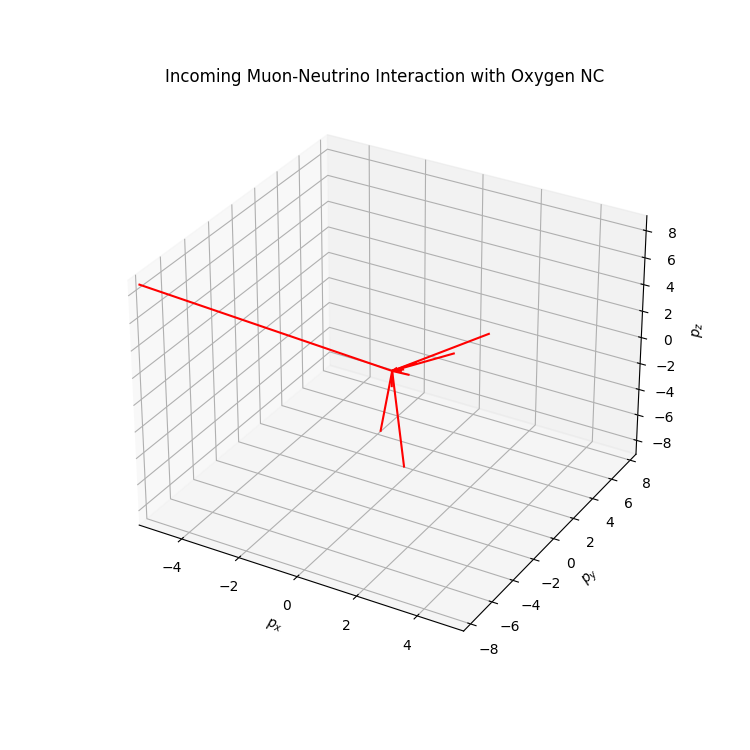

In [24]:
event = 7
momentum_COM = Lorentz_COM(f[event])

perf = np.sum(momentum_COM, axis=0)[2]
print("Performance",perf,"GeV")

fig, ax = plt.subplots(figsize=(7.5,7.5))
ax = plt.axes(projection='3d')
ax.quiver(0, 0, 0, momentum_COM[:,0], momentum_COM[:,1], momentum_COM[:,2], arrow_length_ratio=0, color='red')
ax.set_xlabel('$p_x$')
ax.set_ylabel('$p_y$')
ax.set_zlabel('$p_z$')
ax.set_xlim(-np.max(np.abs(momentum_COM[:,0])),np.max(np.abs(momentum_COM[:,0])))
ax.set_ylim(-np.max(np.abs(momentum_COM[:,1])),np.max(np.abs(momentum_COM[:,1])))
ax.set_zlim(-np.max(np.abs(momentum_COM[:,2])),np.max(np.abs(momentum_COM[:,2])))
ax.set_title("Incoming Muon-Neutrino Interaction with Oxygen NC")
plt.show()
#fig.savefig("LorentzPres.pdf")


# Performance Hydrogen Atom vs Oxygen Atom

In this part is checked how well the Lorentz boost does and especially the interaction with hydrogen and oxygen are compared. This is done by adding the momenta of all particles in the COM-frame in the direction of the neutrino (so which was the boosted direction). When the Lorentz boost is perfect, this should be 0.

In [25]:
length = 500

performance = np.zeros(length)
pdgid_array = np.zeros(length)
event=0

while event < length:
    momentum_COM = Lorentz_COM(f[event])
    perf = np.sum(momentum_COM, axis=0)[2]
    pdgid = f[event].mc_tracks.pdgid[1]
    performance[event] = perf
    pdgid_array[event] = pdgid
    event = event+1


/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/pylorentz/__init__.py:324: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = 1 / np.sqrt(1 - beta**2)
/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/pylorentz/__init__.py:360: RuntimeWarning: invalid value encountered in multiply
  A = (gamma - 1) * (A * A.swapaxes(0, 1))
/project/antares/jurjanbootsma/venv/lib64/python3.6/site-packages/pylorentz/__init__.py:370: RuntimeWarning: invalid value encountered in multiply
  B = gamma * B


In [26]:
perf_hydrogen = performance[(pdgid_array==2212)*(f.w2list[:,9][:length]==3)]
perf_oxygen = performance[(pdgid_array==1000080160)*(f.w2list[:,9][:length]==3)]

print("Mean extra momentum in Lorentz boost direction:")
print("Hydrogen: ", np.mean(np.abs(perf_hydrogen)), "GeV")
print("Oxygen: ", np.mean(np.abs(perf_oxygen)), "GeV")
print()

print("Maximum extra momentum in Lorentz boost direction:")
print("Hydrogen: ", np.max(np.abs(perf_hydrogen)), "GeV")
print("Oxygen: ", np.max(np.abs(perf_oxygen)), "GeV")

Mean extra momentum in Lorentz boost direction:
Hydrogen:  0.00554831325304238 GeV
Oxygen:  0.865127412638956 GeV

Maximum extra momentum in Lorentz boost direction:
Hydrogen:  0.03153570643416226 GeV
Oxygen:  4.032634405314807 GeV


# Extra Energy Needed For Oxygen Atom

To figure out what might be the reason for the bad performance of the Lorentz boost with the interactions with oxygen, the equation for the relativistic speed of the COM-frame is expanded with an extra term $E_{missing}$. Here there is fitted to get a perfect Lorentz boost (meaning that all the added momenta are 0) and then there is looked how much $E_{missing}$ should be added to do this. That gives an interesting histogram.

$$\beta_{COM} = \frac{p_{\nu}}{E_0} = \frac{p_{\nu}}{E_{\nu} + m_{nucleon} + E_{missing}}$$

In [27]:
from scipy.optimize import curve_fit

In [28]:
def Lorentz_COM_test(f_event):
    momentum = particles_momentum(f_event)
    r_mom_ne, theta_mom_ne, phi_mom_ne = polar(momentum[1][0],momentum[2][0],momentum[0][0])
    energy_ne = f_event.mc_tracks.E[0]
    energies = f_event.mc_tracks.E[2:] #Energy
    
    r_moms, theta_moms, phi_moms = polar(momentum[1][2:],momentum[2][2:],momentum[0][2:])
    
    etas = -np.log(np.tan(theta_moms/2))
    
    particles = pl.Momentum4.e_eta_phi_p(energies,etas,phi_moms,r_moms)
    
    def func(x, beta):
        lorentz = particles.boost(0,0,1,beta=beta)
        theta = 2*np.arctan(np.exp(-lorentz.eta))
    
        cartesian = kp.math.cartesian(lorentz.phi, theta, radius=lorentz.p)
        relative = (np.sum(cartesian, axis=0))[2]
        return relative
    
    
    popt, pcov = curve_fit(func, [0,0], [0,0], bounds=(0,1))
    
    mass_nucl_fit = (energy_ne/popt[0]) - energy_ne
    
    mass_nucl_analytic = initial_energy(f_event) - energy_ne
    
    return (mass_nucl_fit - mass_nucl_analytic)
    

In [29]:
length = 500

missing_energies = np.zeros(length)
pdgid_array = np.zeros(length)
event=0

while event < length:
    missing_energy = Lorentz_COM_test(f[event])
    missing_energies[event] = missing_energy
    pdgid = f[event].mc_tracks.pdgid[1]
    pdgid_array[event] = pdgid
    event=event+1

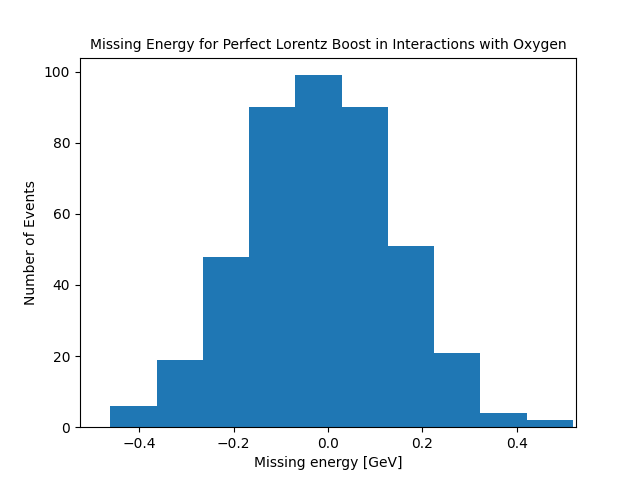

In [30]:
missing_energies_oxygen = missing_energies[pdgid_array==1000080160]

fig=plt.figure()
plt.title("Missing Energy for Perfect Lorentz Boost in Interactions with Oxygen",fontsize=10)
plt.hist(missing_energies_oxygen)
plt.ylabel("Number of Events")
plt.xlabel("Missing energy [GeV]")
plt.xlim(-0.525,0.525)
plt.show()